In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/patient_provider')

In [3]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import argparse
import secrets
import json
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 

In [4]:
from patient.utils import get_results_matching_parameters,aggregate_data, aggregate_normalize_data

In [5]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [6]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [7]:
colors_by_method = {}
baseline_methods = ['random','greedy']
offline_methods = ['offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match']
patient_provider_methods = ['more_patients_than_providers','more_patients_than_providers_2']

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(offline_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(offline_methods)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(offline_methods):
    colors_by_method[m] = vidris[i]
for i,m in enumerate(patient_provider_methods):
    colors_by_method[m] = wistia[i]
colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

In [8]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(baseline_methods+offline_methods):
    shapes_by_method[m] = all_shapes[i%len(all_shapes)]

# ML4H Plots

## Performance Comparison

Biparitte < group p 0.007756846915307151
Biparitte < group p 0.0002528480473506362
Biparitte < group p 0.000556232874773618
Biparitte < group p 0.2878749861924543
Biparitte < group p 0.7089145712915621


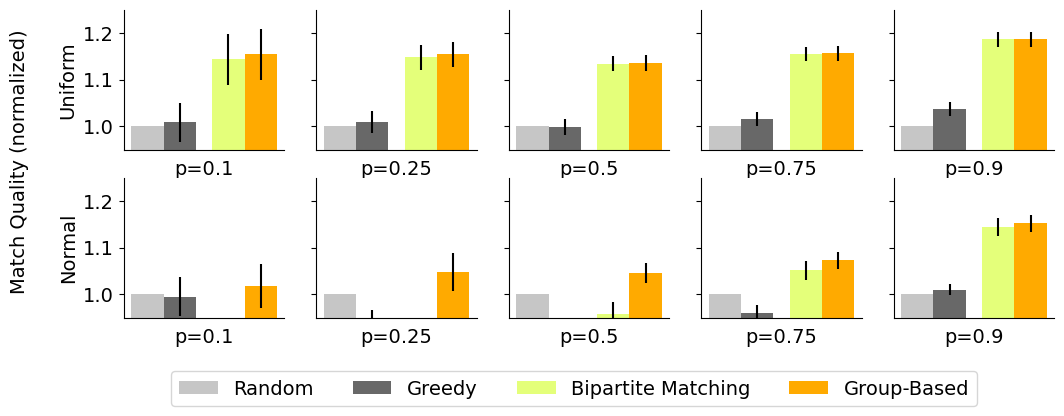

In [12]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_swaps']
nice_names = ["Random","Greedy","Bipartite Matching","Group-Based"]
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 10, 'num_patients': 25, 'num_providers': 25}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "policy_comparison"
            
            temp_params = deepcopy(baseline_params)
            results = get_results_matching_parameters(dataset,"",temp_params)

            if k == 0:
                greedy_values = list(np.array([i['greedy_utilities'] for i in results]).flatten())
                random_values = list(np.array([i['random_utilities'] for i in results]).flatten())
                bipartite_values = list(np.array([i['offline_solution_utilities'] for i in results]).flatten())
                group_values = list(np.array([i['offline_solution_swaps_utilities'] for i in results]).flatten())

                p_vals = [stats.ttest_ind(greedy_values,group_values).pvalue,stats.ttest_ind(random_values,group_values).pvalue]
                # print("Group > All Policies p<",max(p_vals))

                if func == "normal":
                    p_val = stats.ttest_ind(bipartite_values,group_values).pvalue 
                    print("Biparitte < group p {}".format(p_val))

            num_data = 0
            if len(results)>0:
                num_data = len(results)
            if num_data>0:
                results = aggregate_normalize_data(results,baseline="random")
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                
                if k ==0:
                    greedy_values = results['greedy_utilities'][0]
                    random_values = results['random_utilities'][0]
                    bipartite_values = results['offline_solution_utilities'][0]
                    group_values = results['offline_solution_swaps_utilities'][0]

                    # if func == 'uniform':
                    #     print("Policies are within {}".format(bipartite_values/group_values))
                    # print("For {} func, group vs. greedy {}".format(func,group_values/greedy_values))
                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/utility_comparison.pdf",dpi=300, bbox_inches='tight')


### Small Patients, Providers

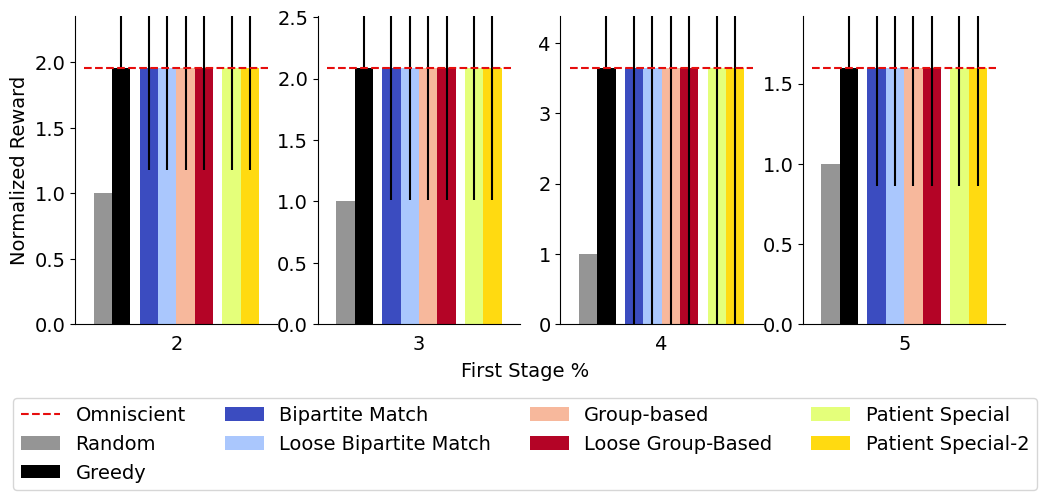

<Figure size 700x400 with 0 Axes>

In [78]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_patients': 1}
dataset = "small"
num_providers = [2,3,4,5]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_providers'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            max_val = results['{}_utilities'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_patients.pdf",dpi=300, bbox_inches='tight')


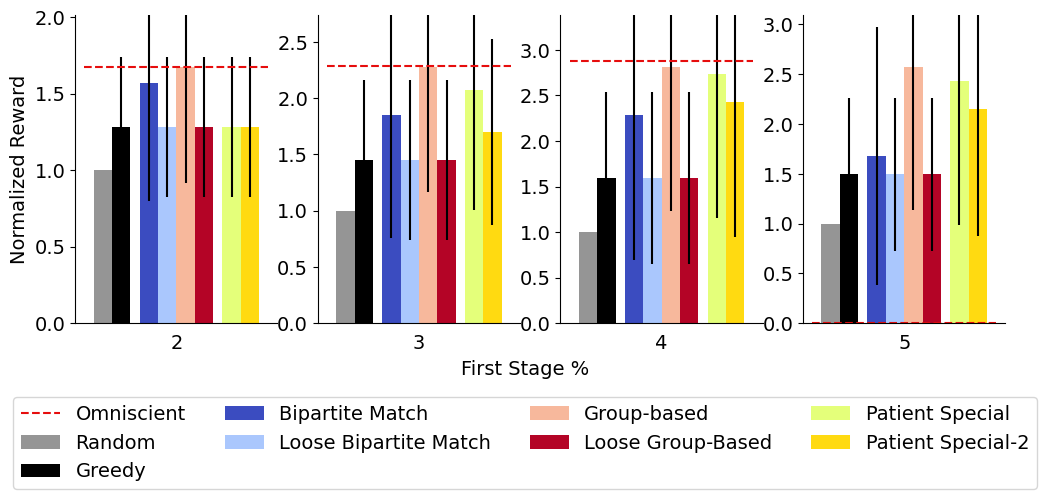

<Figure size 700x400 with 0 Axes>

In [61]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 1}
dataset = "small"
num_patients = [2,3,4,5]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_patients)):
    baseline_params['num_patients'] = num_patients[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(num_patients[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_providers.pdf",dpi=300, bbox_inches='tight')


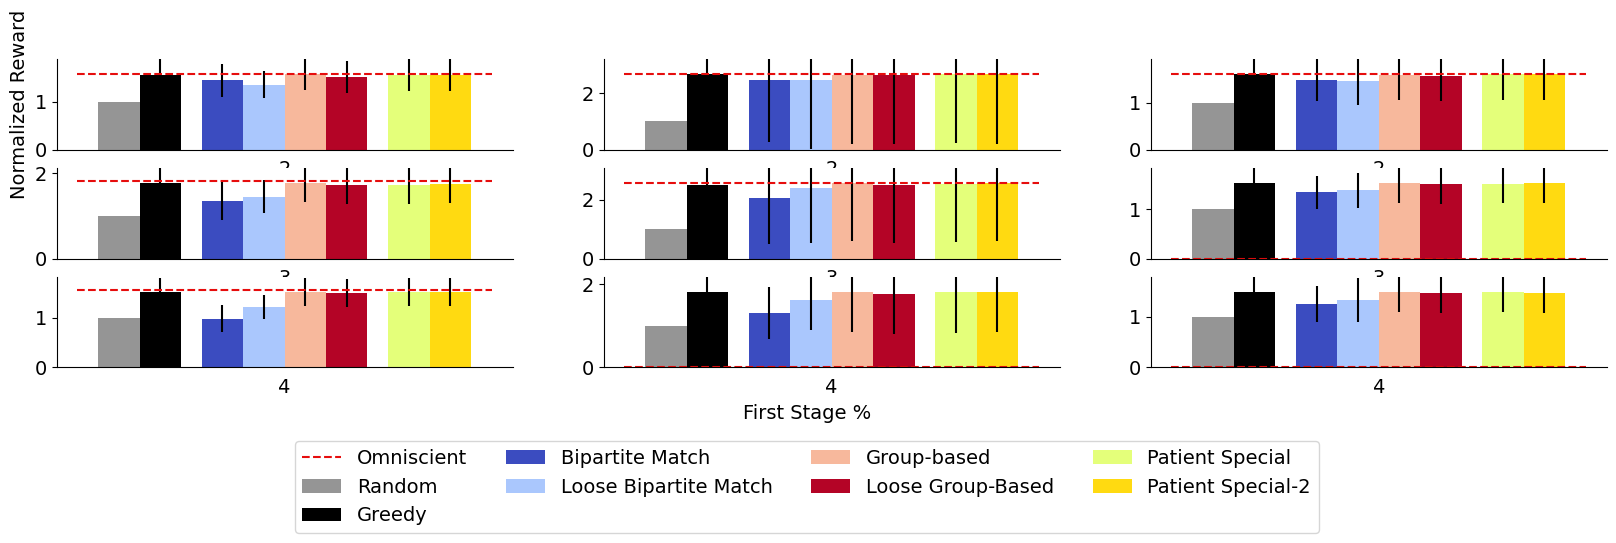

<Figure size 700x400 with 0 Axes>

In [65]:
fig, axs = plt.subplots(3,3, figsize=(20, 4))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'normal', 'num_providers': 1}
dataset = "small"
num_patients = [2,3,4]
num_providers = [2,3,4]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_patients)):
    for j in range(len(num_providers)):
        baseline_params['num_patients'] = num_patients[i]
        baseline_params['num_providers'] = num_providers[j]
        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)

        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        results = aggregate_normalize_data(results,baseline='random')

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].set_xticks([])
            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0,max_val*1.2])
            axs[i][j].set_xlabel(num_patients[i],fontsize=14)
            

axs[0][0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_providers.pdf",dpi=300, bbox_inches='tight')


## Patients vs. Providers

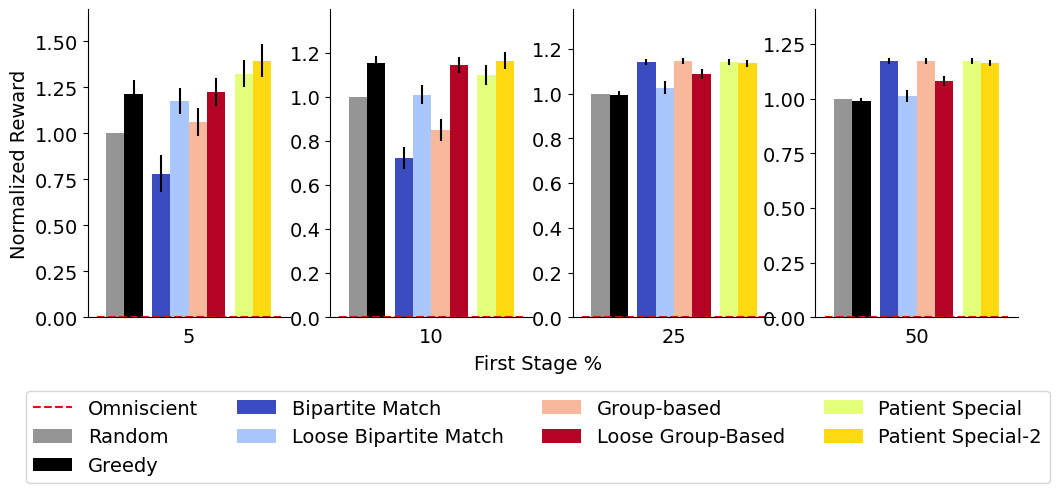

<Figure size 700x400 with 0 Axes>

In [77]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_patients': 25}
dataset = "providers_patients"
num_providers = [5,10,25,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_providers'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_patients.pdf",dpi=300, bbox_inches='tight')


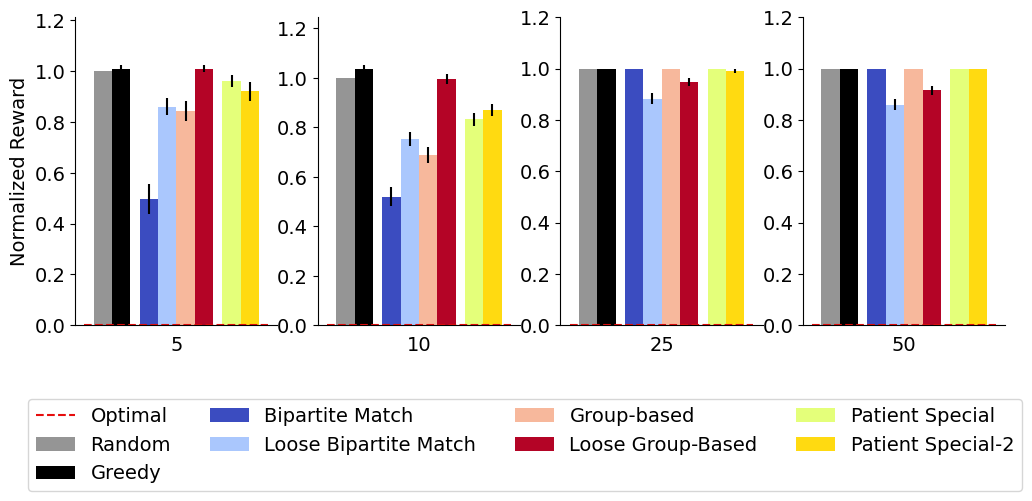

<Figure size 700x400 with 0 Axes>

In [17]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_patients': 25}
dataset = "providers_patients"
num_providers = [5,10,25,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_providers'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_matches'.format(m) not in results:
            results['{}_matches'.format(m)] = [0,0]
        score_by_n.append(results['{}_matches'.format(m)][0])
        std_by_n.append(results['{}_matches'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_matches'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_patients.pdf",dpi=300, bbox_inches='tight')


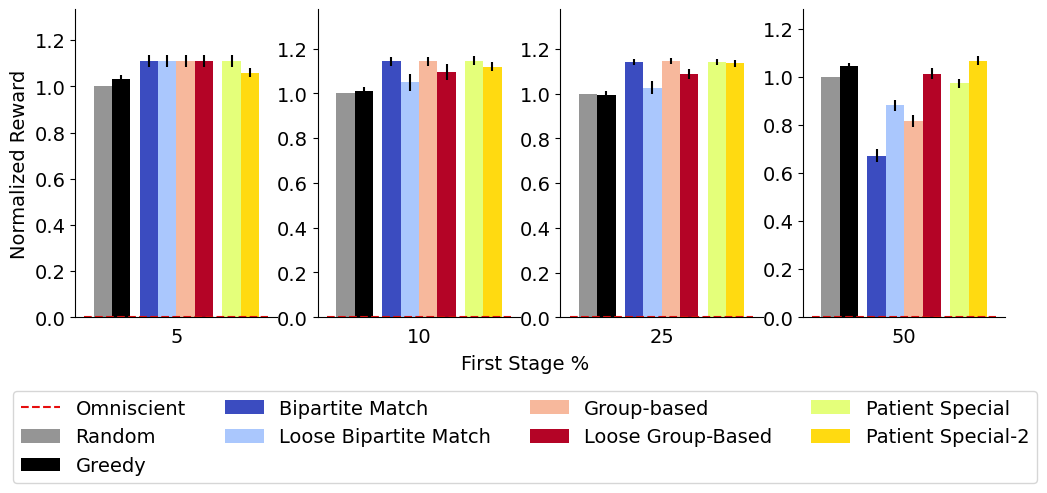

<Figure size 700x400 with 0 Axes>

In [75]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25}
dataset = "providers_patients"
num_providers = [5,10,25,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_patients'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_patients.pdf",dpi=300, bbox_inches='tight')


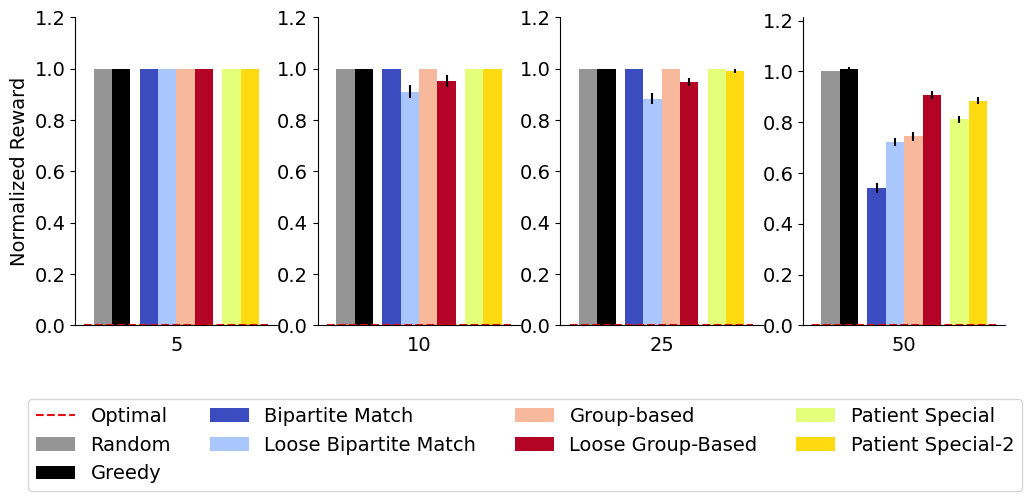

<Figure size 700x400 with 0 Axes>

In [16]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25}
dataset = "providers_patients"
num_providers = [5,10,25,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_patients'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_matches'.format(m) not in results:
            results['{}_matches'.format(m)] = [0,0]
        score_by_n.append(results['{}_matches'.format(m)][0])
        std_by_n.append(results['{}_matches'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_matches'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_patients.pdf",dpi=300, bbox_inches='tight')


## Misspecification

0 3 15
0 4 15
0 5 15
1 2 15
1 3 15
1 4 15
1 5 15
2 1 15
2 2 15
2 3 15
2 4 15
2 5 15
3 0 15
3 1 15
3 2 15
3 3 15
3 4 15
4 0 15
4 1 15
4 2 15
4 3 15


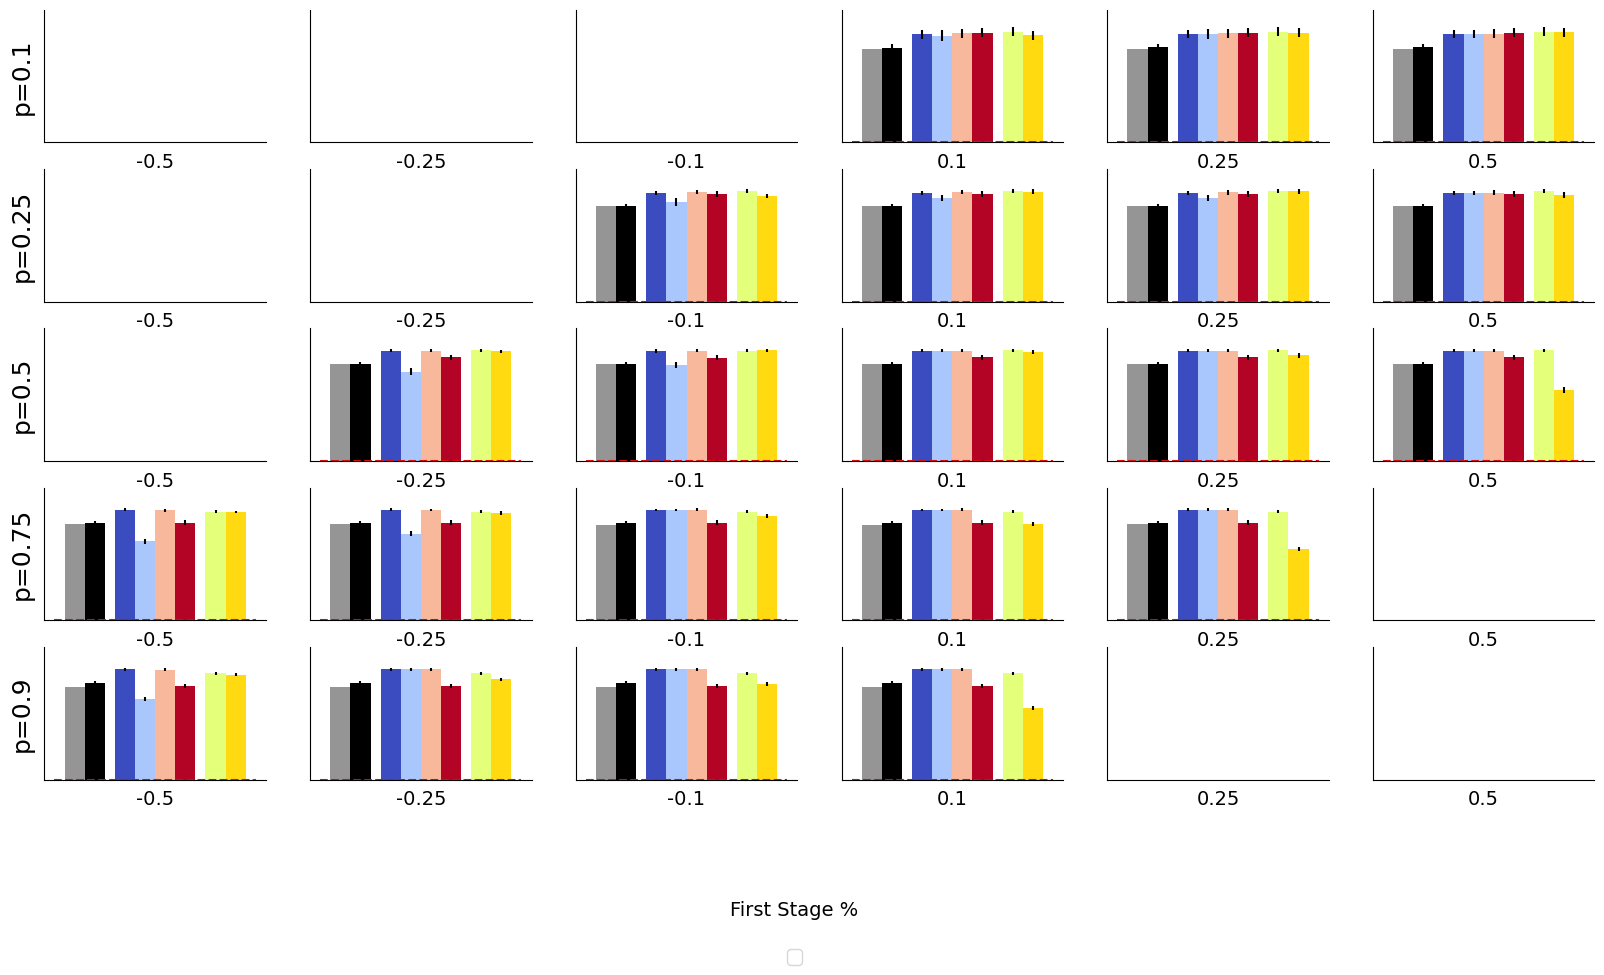

<Figure size 700x400 with 0 Axes>

In [19]:
fig, axs = plt.subplots(5,6, figsize=(20, 10))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5}
dataset = "misspecification"
choice_prob = [0.1,0.25,0.5,0.75,0.9]
shift_list = [-0.5,-0.25,-0.1,0.1,0.25,0.5]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(choice_prob)):
    for j in range(len(shift_list)):
        baseline_params['true_top_choice_prob'] = choice_prob[i]
        baseline_params['top_choice_prob'] = choice_prob[i]+shift_list[j]
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_xlabel(shift_list[j],fontsize=14)
        if j == 0:
            axs[i][j].set_ylabel("p="+str(choice_prob[i]))        

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)

        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        if num_data == 0:
            continue 
        
        results = aggregate_normalize_data(results,baseline='random')

        print(i,j,num_data)

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)
        

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0,max_val*1.2])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_providers.pdf",dpi=300, bbox_inches='tight')


0 3 15
0 4 15
0 5 15
1 2 15
1 3 15
1 4 15
1 5 15
2 1 15
2 2 15
2 3 15
2 4 15
2 5 15
3 0 15
3 1 15
3 2 15
3 3 15
3 4 15
4 0 15
4 1 15
4 2 15
4 3 15


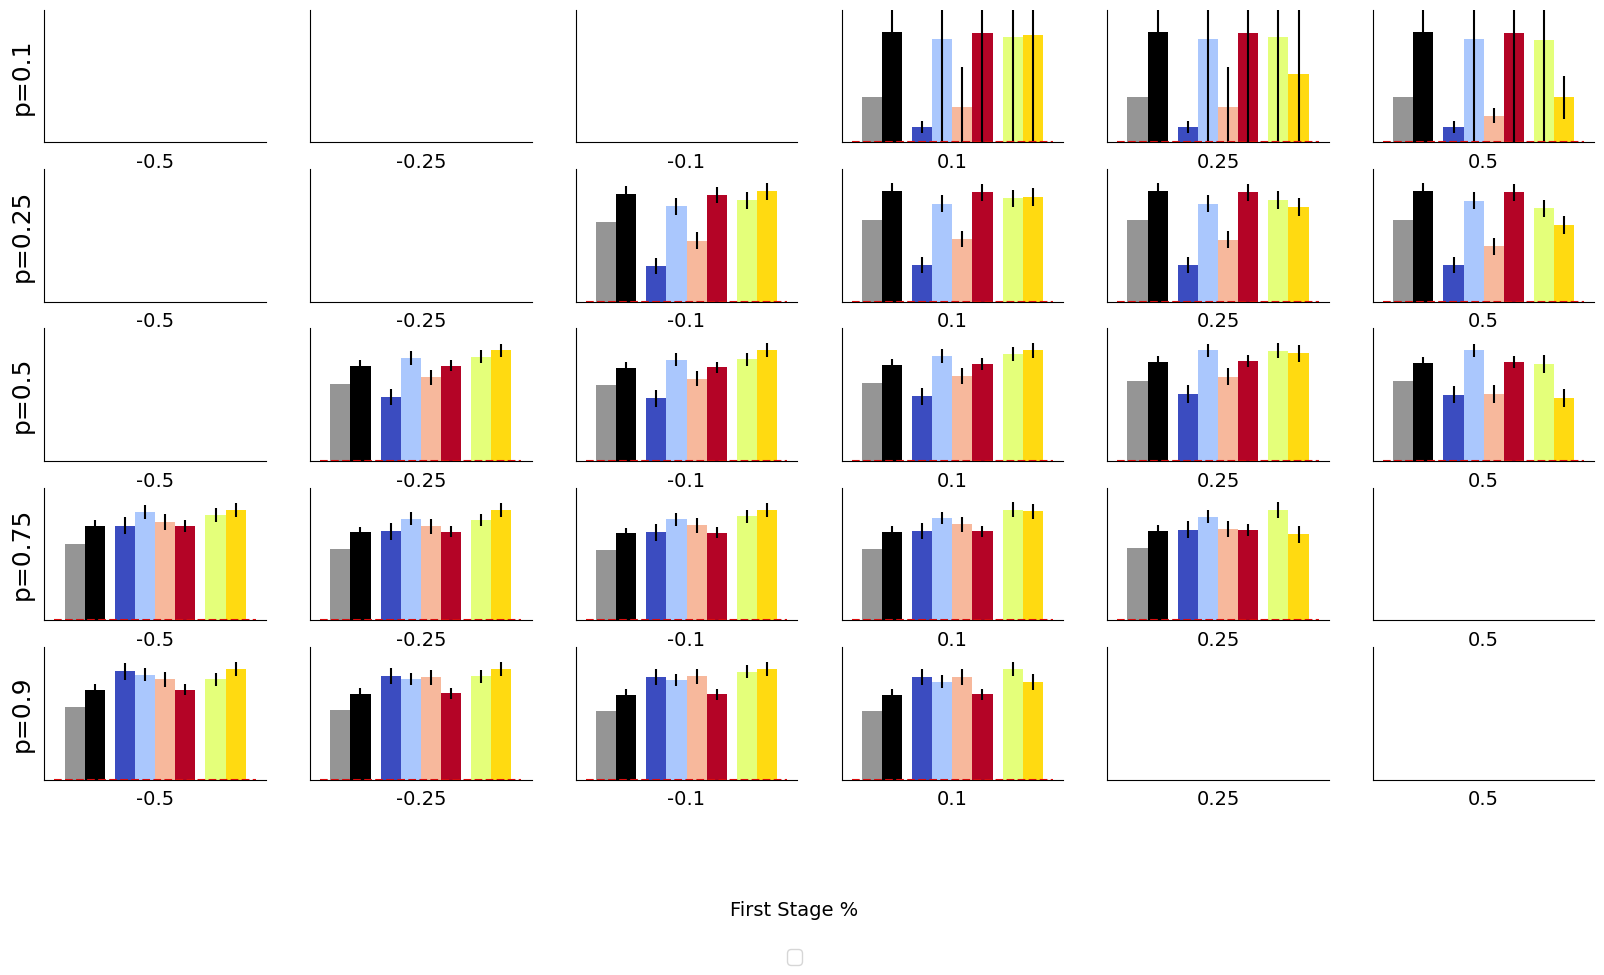

<Figure size 700x400 with 0 Axes>

In [20]:
fig, axs = plt.subplots(5,6, figsize=(20, 10))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 5, 'num_patients': 25, 'exit_option': 0.5}
dataset = "misspecification"
choice_prob = [0.1,0.25,0.5,0.75,0.9]
shift_list = [-0.5,-0.25,-0.1,0.1,0.25,0.5]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(choice_prob)):
    for j in range(len(shift_list)):
        baseline_params['true_top_choice_prob'] = choice_prob[i]
        baseline_params['top_choice_prob'] = choice_prob[i]+shift_list[j]
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_xlabel(shift_list[j],fontsize=14)
        if j == 0:
            axs[i][j].set_ylabel("p="+str(choice_prob[i]))        

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)

        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        if num_data == 0:
            continue 
        
        results = aggregate_normalize_data(results,baseline='random')

        print(i,j,num_data)

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)
        

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0,max_val*1.2])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_providers.pdf",dpi=300, bbox_inches='tight')


0 0 15
0 1 15
0 2 15
0 3 15
1 0 15
1 1 15
1 2 15
1 3 15
2 0 15
2 1 15
2 2 15
2 3 15
3 0 15
3 1 15
3 2 15
3 3 15
4 0 15
4 1 15
4 2 15
4 3 15


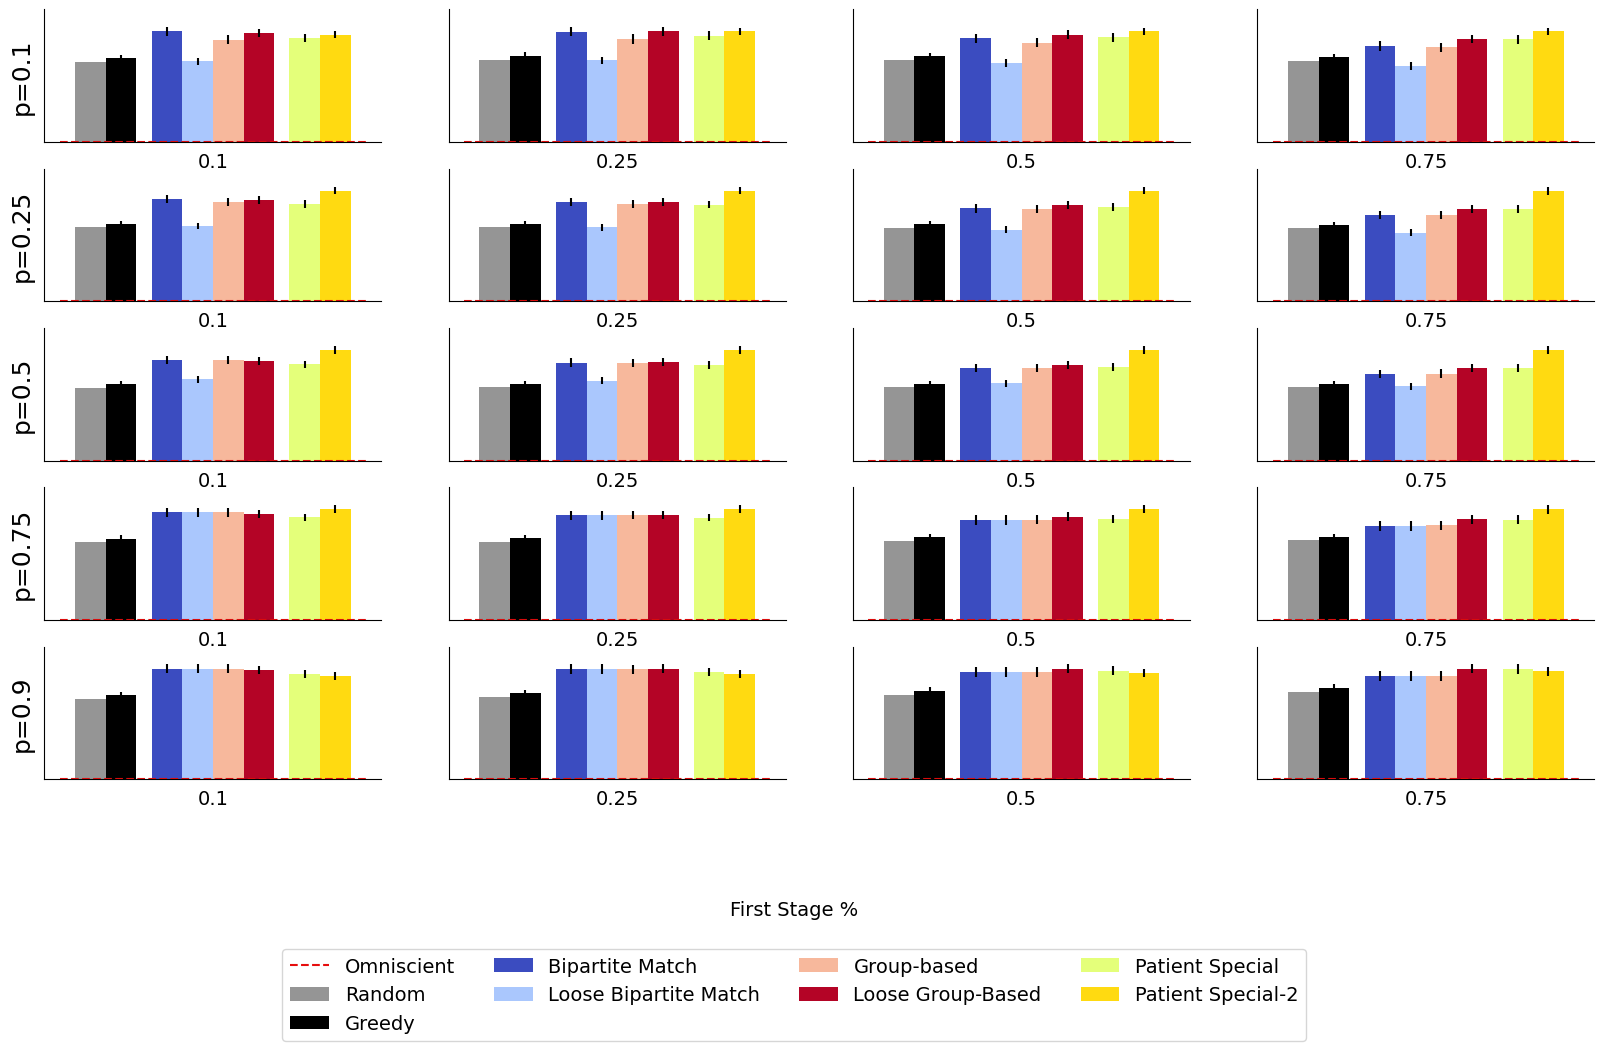

<Figure size 700x400 with 0 Axes>

In [24]:
fig, axs = plt.subplots(5,4, figsize=(20, 10))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5}
dataset = "misspecification"
choice_prob = [0.1,0.25,0.5,0.75,0.9]
exit_options = [0.1,0.25,0.5,0.75]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(choice_prob)):
    for j in range(len(exit_options)):
        baseline_params['true_top_choice_prob'] = choice_prob[i]
        baseline_params['top_choice_prob'] = choice_prob[i]
        baseline_params['exit_option'] = exit_options[j]
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_xlabel(exit_options[j],fontsize=14)
        if j == 0:
            axs[i][j].set_ylabel("p="+str(choice_prob[i]))        

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)

        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        if num_data == 0:
            continue 
        
        results = aggregate_normalize_data(results,baseline='random')

        print(i,j,num_data)

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)
        

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0,max_val*1.2])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)
fig.savefig("../../results/figures/small_providers.pdf",dpi=300, bbox_inches='tight')


## Ordering

0 0 15
0 1 15
0 2 15
1 0 15
1 1 15
1 2 15
2 0 15
2 1 15
2 2 15
3 0 15
3 1 15
3 2 15
4 0 15
4 1 15
4 2 15


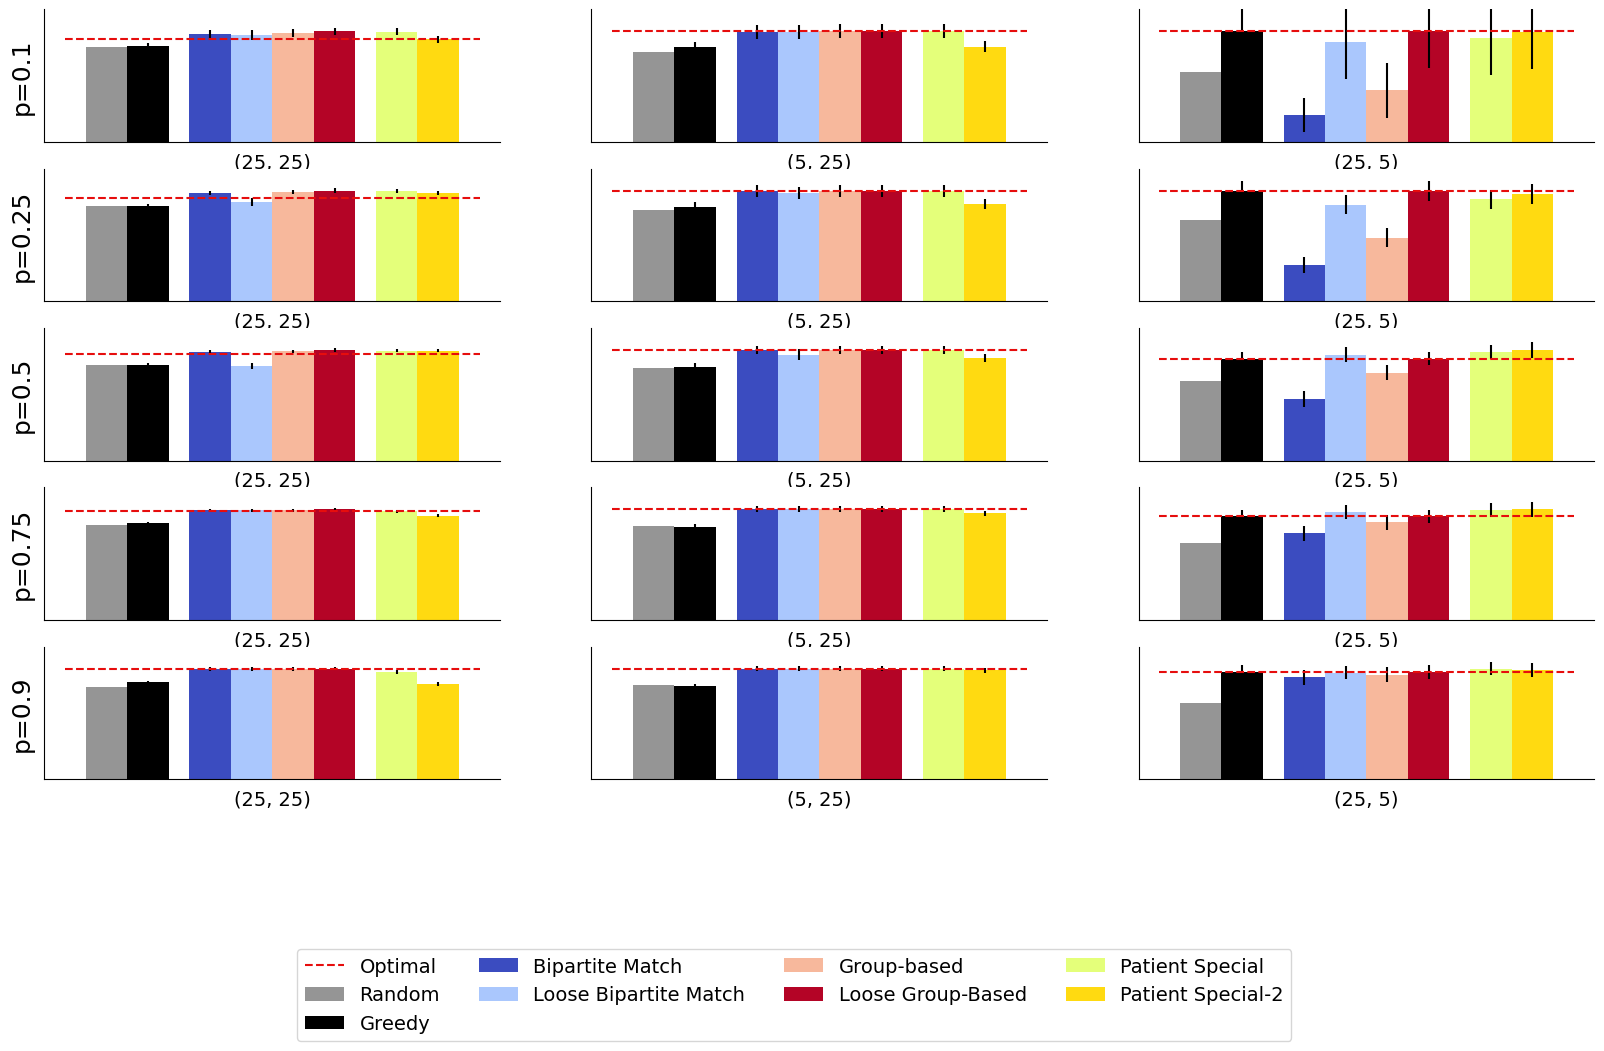

<Figure size 700x400 with 0 Axes>

In [12]:
fig, axs = plt.subplots(5,3, figsize=(20, 10))
method_names = ['random','greedy','offline_solution','offline_solution_loose_constraints','offline_solution_swaps','offline_solution_swaps_no_match','more_patients_than_providers','more_patients_than_providers_2','optimal_order']
nice_names = ["Random","Greedy","Bipartite Match","Loose Bipartite Match","Group-based", "Loose Group-Based","Patient Special","Patient Special-2","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform'}
dataset = "ordering"
choice_prob = [0.1,0.25,0.5,0.75,0.9]
patient_providers = [(25,25),(5,25),(25,5)]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(choice_prob)):
    for j in range(len(patient_providers)):
        baseline_params['true_top_choice_prob'] = choice_prob[i]
        baseline_params['top_choice_prob'] = choice_prob[i]
        baseline_params['num_patients'] = patient_providers[j][0]
        baseline_params['num_providers'] = patient_providers[j][1]

        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_xlabel(patient_providers[j],fontsize=14)
        if j == 0:
            axs[i][j].set_ylabel("p="+str(choice_prob[i]))        

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)

        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        if num_data == 0:
            continue 
        
        results = aggregate_normalize_data(results,baseline='random')

        print(i,j,num_data)

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)
        

            if m == 'optimal_order':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method['optimal'])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0,max_val*1.2])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)
fig.savefig("../../results/figures/small_providers.pdf",dpi=300, bbox_inches='tight')
